# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString, MultiLineString, Polygon
import matplotlib.pylab as plt
import gzip
from tqdm import tqdm

# Load data

In [12]:
df = gpd.read_file('raw/comptages-en-section-tous-vehicules.geojson')

In [13]:
df.columns

Index(['geo_point_2d', 'street', 'motdir', 'id_seg_ges', 'commune',
       'code_insee', 'codsti', 'date', 'an', 'section', 'sens_comptage',
       'voie_en_sensunique', 'type', 'tmjo_tv', 'nb_veh_jour_charge',
       'jour_plus_charge', 'hpm', 'h_matin', 'hps', 'h_soir', 'comptage_pl',
       'tmjo_pl', 'nb_pl_jour_charge', 'jour_plus_charge_pl',
       'limitation_vitesse', 'v85', 'date_maj_tab', 'pole', 'observations',
       'geometry'],
      dtype='object')

In [14]:
df.an.unique()

array([2021., 2022., 2023., 2020., 2019., 2018.])

In [15]:
df['type'].unique()

array(['VELO', 'TV'], dtype=object)

In [16]:
# Remove bicycle
df = df[df['type'] == 'TV']

In [17]:
df[[
    'date', 'an', 'section', 'sens_comptage',
       'voie_en_sensunique', 'type', 'tmjo_tv', 'nb_veh_jour_charge',
        'comptage_pl',
       'tmjo_pl', 
       'limitation_vitesse', 'v85', 'date_maj_tab', 'pole', 'observations',
       'geometry'
]].head()

,date,an,section,sens_comptage,voie_en_sensunique,type,tmjo_tv,nb_veh_jour_charge,comptage_pl,tmjo_pl,limitation_vitesse,v85,date_maj_tab,pole,observations,geometry
1,2021-11-29,2021.0,ENTRE AV JEAN RIEUX ET AV DE ST-EXUPERY,VERS AV DE ST-EXUPERY,NON,TV,782,804,OUI,17,30,46,2022/01/25,EST,None,"LINESTRING (1.47896 43.58044, 1.48018 43.58182..."
2,2021-11-29,2021.0,ENTRE AV JEAN RIEUX ET AV DE ST-EXUPERY,VERS AV RIEUX,NON,TV,343,423,OUI,4,30,41,2022/01/25,EST,None,"LINESTRING (1.47896 43.58044, 1.48018 43.58182..."
3,2021-11-29,2021.0,ENTRE RUE ENGALIERES ET RUE PIERRE LAUZERAL,VERS RUE ENGALIERES,NON,TV,1438,1537,OUI,18,50,42,2022/01/25,EST,None,"LINESTRING (1.48024 43.5819, 1.48106 43.58132)"
4,2021-11-29,2021.0,ENTRE RUE ENGALIERES ET RUE PIERRE LAUZERAL,VERS RUE LAUZERAL,NON,TV,1993,2273,OUI,45,50,54,2022/01/25,EST,None,"LINESTRING (1.48024 43.5819, 1.48106 43.58132)"
5,2021-12-06,2021.0,ENTRE RUE DU TARN ET RUE DU TARN,VERS CHE CLABEL,NON,TV,587,641,OUI,13,30,36,2022/01/25,EST,None,"LINESTRING (1.48177 43.58146, 1.48269 43.58227)"


In [18]:
df.observations.unique()

array([None, 'CONTRE-SENS', 'rue barrée les 23,24 et 25 mars',
       'voie de bus', 'RAPPORT COMPTAGE PARTIEL',
       'contre-sens (voie de bus)',
       'TMJO sur 4jours (pas de Lundi de Pentecôte)',
       'TMJO sur 4 jours (pas de lundi de pentecôte)',
       'TMJO sur 4jours (pas de lundi de pentecôte',
       'BRETELLE DE SORTIE A62', 'SENS INTERDIT',
       'SENS UNIQUE DURANT TRAVAUX - section nord', 'SECTEUR NORD',
       'SECTEUR SUD',
       'TRAVAUX PLACE ST PIERRE - COMPTAGE SUR 3 JOURS (MMJ)',
       'contre-sens', "EN SENS UNIQUE JUSQU'EN 2019",
       'COMPTAGE SUR 2 JOURS', 'POINT CONSEIL DEPARTEMENTAL',
       "COTE RUE DE L'INDUSTRIE",
       "Dans l'intranet Sesame, choisir le service 'Gestion des Infrastructures'",
       'TMJO sur 4 jour (pas de Lundi de Pentecôte)',
       'COMPTAGE DANS UN SEUL SENS',
       'Comptage effectué dans les deux sens pour cause de travaux. Autre sens TMJO 16',
       'S', 'partie sud du chemin',
       'SENS UNIQUE + VOIE DE BUS AUT

In [19]:
df.shape

(5458, 30)

In [20]:
df.observations.isna().sum()

5380

In [21]:
# Remove perturbed values where there are observations
df = df[df.observations.isna()]

In [22]:
df.rename(columns = {
    'tmjo_tv' : 'AAWT', 
       'tmjo_pl' : 'TR_AAWT',  
       'v85' : 's85', 
       'street':'raw_name',
       'sens_comptage':'raw_direction'
}, inplace=True)

(1.0543441772460938,
 1.7574736496822148,
 43.452897006160995,
 43.834774435190745)

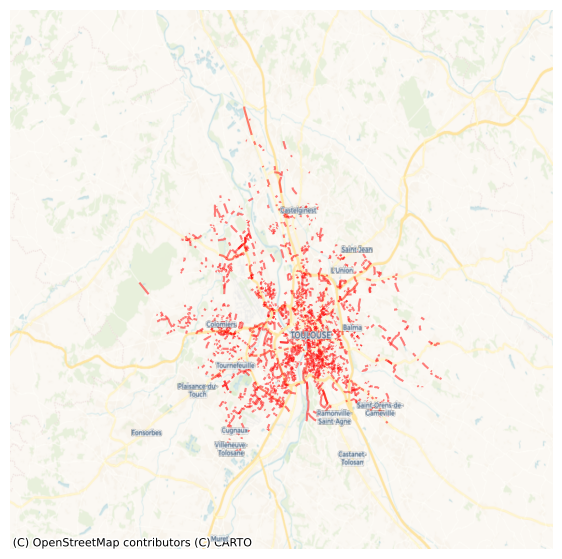

In [23]:
import contextily as cx

# Plot sensors
ax = df.drop_duplicates(subset = ['geometry']).plot(color = 'r', markersize = 20, alpha = .5, figsize = (7,7))
# Add context in backround
cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [24]:
df[[
    'an', 'AAWT', 'TR_AAWT', 's85', 'raw_name', 'raw_direction', 'geometry'
    ]].drop_duplicates(subset = ['geometry']).shape

(2412, 7)

In [29]:
df.raw_direction.value_counts().sort_index()

raw_direction
LES DEUX SENS                 6
RUE DE L'AUVERGNE             1
SENS ENTRANT                  1
SENS SORTANT                  1
SENS UNIQUE VERS CAZENEUVE    1
                             ..
VERSCHE DE LA LAUBAREDE       1
VERSENTREE CLINIQUE           1
VERSIMP UNIS                  1
VERSRTE DE TOURNEFEUILLE      1
vERS JACQUES GAMELIN          1
Name: count, Length: 3261, dtype: int64

In [37]:
df['raw_oneway'] = True
df.loc[df.raw_direction == 'LES DEUX SENS', 'raw_oneway'] = False
df.loc[df.raw_direction == 'LES DEUX SENS', 'raw_direction'] = np.nan

# Map Matching with OSM

In [32]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import lines_matching

In [33]:
df.geometry.unique().size

2412

In [34]:
df = lines_matching(df)

Main graph loaded
Node 1132685899 not reachable from 518355054
Node 2049077178 not reachable from 518355054
Node 1167682136 not reachable from 518355054
Node 1182973496 not reachable from 518355054
Node 1135505334 not reachable from 518355054
Node 1115375156 not reachable from 518355054
Node 1182973496 not reachable from 518355054
Node 1116323384 not reachable from 518355054
Node 1135505334 not reachable from 518355054
Node 1115375156 not reachable from 518355054
Node 1132685899 not reachable from 518355054
Node 2049077178 not reachable from 518355054
Node 1167682136 not reachable from 518355054
Node 1182973496 not reachable from 518355054
Node 1135505334 not reachable from 518355054
Node 1115375156 not reachable from 518355054
Node 1182973496 not reachable from 518355054
Node 1116323384 not reachable from 518355054
Node 1135505334 not reachable from 518355054
Node 1115375156 not reachable from 518355054
Node 1132685899 not reachable from 518355054
Node 2049077178 not reachable from 51

In [35]:
df[['raw_name', 'osm_name']].dropna().drop_duplicates()[:20]

,raw_name,osm_name
1,RUE ENGALIERES,Rue Engalières
3,AV JEAN RIEUX,Avenue Jean Rieux
5,RUE DE L ARIEGE,Rue de l'Ariège
6,CHE MAL CLABEL,Chemin Mal Clabel
7,RUE PIERRE LAUZERAL,Rue Pierre Lauzeral
9,AV ANTOINE DE ST EXUPERY,Avenue Antoine de Saint-Exupéry
10,AV LOUIS BREGUET,Avenue Louis Breguet
12,RTE DE REVEL,Route de Revel
13,CHE DE LA TERRASSE,Chemin de la Terrasse
16,RUE DU PORTILLON,Rue du Portillon


# Final Saving

In [40]:
# Saving
for year in df.an.unique() :
    # Extract corresponding year
    sub = df[df.an == year]
    print(year, sub.shape[0])
    sub[[
        'AAWT', 'TR_AAWT', 's85', 'geometry', 'raw_name', 'raw_oneway', 'raw_direction', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osmid'
        ]].to_file(f'treated/Toulouse_AAWT_{int(year)}.geojson')

2021.0 1177
2022.0 1315
2023.0 678
2020.0 680
2019.0 702
2018.0 828
